In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import yfinance as yf
import optuna

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

optuna.logging.set_verbosity(optuna.logging.WARNING)
print(f"TensorFlow version: {tf.__version__}")
print(f"Running from: {sys.executable}")

c:\capstone_project_unfc\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TensorFlow version: 2.20.0
Running from: c:\capstone_project_unfc\env\Scripts\python.exe


In [2]:
# 1. SETUP PATHS
CURRENT_DIR = Path.cwd()
# Adjust REPO_ROOT to your local machine path (e.g., C:\capstone_project_unfc)
REPO_ROOT = CURRENT_DIR.parent.parent

# 2. FETCH DATA
SYMBOL = "TSLA"
INTERVAL = "1wk"
PERIOD = "5y"

print(f"Fetching data for {SYMBOL}...")
df = yf.download(tickers=SYMBOL, period=PERIOD, interval=INTERVAL, multi_level_index=False)
df = df.reset_index()
df = df.rename(columns={"Date": "timestamp", "Close": "close"})
# yfinance uses "Volume" (capital V)
if "Volume" not in df.columns:
    df = df.rename(columns={c: "Volume" for c in df.columns if c.lower() == "volume"})
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp")

# Create clean series: close and volume (aligned, dropna)
ts = df.set_index("timestamp")
prices = ts["close"].astype(float)
volume = ts["Volume"].astype(float)
valid = prices.notna() & volume.notna()
prices = prices[valid].dropna()
volume = volume[valid].dropna()
# Ensure same index
volume = volume.reindex(prices.index).ffill().bfill()

print(f"Loaded {len(prices)} rows. Latest date: {prices.index.max()}")
print(f"Volume range: {volume.min():.0f} - {volume.max():.0f}")

prices.head()


Fetching data for TSLA...


[*********************100%***********************]  1 of 1 completed

Loaded 262 rows. Latest date: 2026-02-23 00:00:00
Volume range: 174404342 - 1095958300


timestamp
2021-02-22    225.166672
2021-03-01    199.316666
2021-03-08    231.243332
2021-03-15    218.289993
2021-03-22    206.236664
Name: close, dtype: float64

In [3]:
# Configuration (defaults; overwritten by Optuna best params if you run the Optuna cell)
TEST_SIZE = 30
LOOKBACK = 20
EPOCHS = 20
BATCH = 16
LSTM_UNITS = 50
DROPOUT = 0.2
USE_VOLUME = False  # True = use volume as exogenous feature
EMA_SPAN = 10  # for baseline EMA

# Scaling: univariate (close only) for original LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(prices.values.reshape(-1, 1))

# Scaling: bivariate (close + volume) for LSTM with exogenous volume
scaler_2d = MinMaxScaler(feature_range=(0, 1))
data_2d = np.column_stack([prices.values, volume.values])
scaled_data_2d = scaler_2d.fit_transform(data_2d)

def create_sequences(data, window):
    """Univariate: data shape (n,) or (n, 1). Returns X (n_samples, window, 1), y (n_samples,)."""
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i : i + window])
        y.append(data[i + window])
    return np.array(X), np.array(y)

def create_sequences_exog(data_2d, window):
    """Multivariate: data_2d shape (n, 2). Returns X (n_samples, window, 2), y (n_samples,) — y is close only."""
    X, y = [], []
    for i in range(len(data_2d) - window):
        X.append(data_2d[i : i + window])   # (window, 2)
        y.append(data_2d[i + window, 0])    # next close (first column)
    return np.array(X), np.array(y)

In [4]:
# --- Optuna: find best LSTM hyperparameters ---
# Uses a single train/val split (no walk-forward) for speed; best params are then used in backtest below.

def build_lstm(lookback, n_features, units, dropout_rate):
    model = Sequential([
        LSTM(units, return_sequences=False, input_shape=(lookback, n_features)),
        Dropout(dropout_rate),
        Dense(1),
    ])
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

def objective(trial):
    lookback = trial.suggest_int("lookback", 5, 30)
    units = trial.suggest_categorical("lstm_units", [32, 64, 128])
    dropout_rate = trial.suggest_float("dropout", 0.1, 0.4)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    epochs = trial.suggest_int("epochs", 15, 40)
    use_volume = trial.suggest_categorical("use_volume", [True, False])

    train_end = len(prices) - TEST_SIZE
    val_ratio = 0.2
    if use_volume:
        data = scaled_data_2d[:train_end]
        X, y = create_sequences_exog(data, lookback)
        scaler_use = scaler_2d
    else:
        data = scaled_data[:train_end]
        X, y = create_sequences(data, lookback)
        if X.ndim == 2:
            X = X.reshape(X.shape[0], X.shape[1], 1)
        scaler_use = scaler

    if len(X) < 10:
        return float("inf")

    n = len(X)
    n_val = max(1, int(n * val_ratio))
    n_train = n - n_val
    X_train, X_val = X[:n_train], X[n_train:]
    y_train, y_val = y[:n_train], y[n_train:]

    model = build_lstm(lookback, X.shape[2], units, dropout_rate)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    pred_val = model.predict(X_val, verbose=0)
    if use_volume:
        pred_2d = np.column_stack([pred_val, np.tile(data[-1, 1], (len(pred_val), 1))])
        pred_orig = scaler_use.inverse_transform(pred_2d)[:, 0]
    else:
        pred_orig = scaler_use.inverse_transform(pred_val).ravel()
    # True validation targets in original scale (same indices as val sequences)
    start_idx = n_train + lookback
    y_val_orig = prices.iloc[start_idx : start_idx + n_val].values.ravel()
    rmse = sqrt(np.mean((y_val_orig - pred_orig) ** 2))
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25, show_progress_bar=True, n_jobs=1)

best = study.best_params
print("\n--- Best LSTM setup (Optuna) ---")
print(best)
print(f"Best validation RMSE: {study.best_value:.4f}")

# Apply best params for backtest cells below
LOOKBACK = best["lookback"]
LSTM_UNITS = best["lstm_units"]
DROPOUT = best["dropout"]
BATCH = best["batch_size"]
EPOCHS = best["epochs"]
USE_VOLUME = best["use_volume"]

  0%|          | 0/25 [00:00<?, ?it/s]c:\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Best trial: 0. Best value: 37.8493:   4%|▍         | 1/25 [00:15<06:20, 15.83s/it]c:\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Best trial: 0. Best value: 37.8493:   8%|▊         | 2/25 [00:28<05:27, 14.24s/it]c:\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shap

Best trial: 0. Best value: 37.8493:  12%|█▏        | 3/25 [00:43<05:12, 14.22s/it]c:\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Best trial: 3. Best value: 32.1151:  16%|█▌        | 4/25 [01:00<05:21, 15.32s/it]c:\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Best trial: 3. Best value: 32.1151:  20%|██        | 5/25 [01:11<04:36, 13.80s/it]c:\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Se


--- Best LSTM setup (Optuna) ---
{'lookback': 14, 'lstm_units': 128, 'dropout': 0.18361554307243527, 'batch_size': 8, 'epochs': 31, 'use_volume': True}
Best validation RMSE: 28.8366


In [5]:
results = []
split_idx = len(prices) - TEST_SIZE

print(f"Starting Walk-Forward Backtest for {TEST_SIZE} periods...")

for i in range(split_idx, len(prices)):
    # Slice data for the current training window
    current_train = scaled_data[:i]
    X_train, y_train = create_sequences(current_train, LOOKBACK)
    
    # Build Model Architecture
    model = Sequential([
        LSTM(50, return_sequences=False, input_shape=(LOOKBACK, 1)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, verbose=0)
    
    # Forecast 1-step ahead
    last_window = current_train[-LOOKBACK:].reshape(1, LOOKBACK, 1)
    pred_scaled = model.predict(last_window, verbose=0)
    yhat = float(scaler.inverse_transform(pred_scaled)[0, 0])
    
    results.append({
        "timestamp": prices.index[i],
        "y_true": float(prices.iloc[i]),
        "y_pred": yhat
    })

# Create result DataFrame
lstm_results = pd.DataFrame(results).set_index("timestamp")
print("✅ Backtest Complete.")

c:\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Starting Walk-Forward Backtest for 30 periods...


c:\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`

✅ Backtest Complete.


In [6]:
# --- LSTM with volume as exogenous feature (walk-forward) ---
results_exog = []
split_idx = len(prices) - TEST_SIZE
print("Starting Walk-Forward Backtest (LSTM + Volume)...")

for i in range(split_idx, len(prices)):
    current_train = scaled_data_2d[:i]
    X_train, y_train = create_sequences_exog(current_train, LOOKBACK)
    if len(X_train) < 1:
        continue
    model = Sequential([
        LSTM(LSTM_UNITS, return_sequences=False, input_shape=(LOOKBACK, 2)),
        Dropout(DROPOUT),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mean_squared_error")
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH, verbose=0)
    last_window = current_train[-LOOKBACK:].reshape(1, LOOKBACK, 2)
    pred_scaled = model.predict(last_window, verbose=0)
    # Inverse transform: need (1, 2) with [close_pred, volume]; use last known volume for inverse
    pred_2d = np.column_stack([pred_scaled, current_train[-1, 1].reshape(1, 1)])
    yhat = float(scaler_2d.inverse_transform(pred_2d)[0, 0])
    results_exog.append({
        "timestamp": prices.index[i],
        "y_true": float(prices.iloc[i]),
        "y_pred": yhat
    })

lstm_exog_results = pd.DataFrame(results_exog).set_index("timestamp")
print("LSTM+Volume backtest complete.")

Starting Walk-Forward Backtest (LSTM + Volume)...


c:\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\capstone_project_unfc\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`

LSTM+Volume backtest complete.


In [7]:
# --- EMA baseline (walk-forward, 1-step ahead) ---
# Forecast = last EMA value of close (expanding window up to t-1, predict for t)
def ema_series(close, span):
    alpha = 2.0 / (span + 1)
    ema = np.empty_like(close, dtype=float)
    ema[0] = close[0]
    for i in range(1, len(close)):
        ema[i] = alpha * close[i] + (1 - alpha) * ema[i - 1]
    return ema

ema_results = []
split_idx = len(prices) - TEST_SIZE
print("Starting EMA baseline backtest...")

for i in range(split_idx, len(prices)):
    current_close = prices.values[:i]
    ema = ema_series(current_close, EMA_SPAN)
    yhat = float(ema[-1])  # 1-step forecast = last EMA
    ema_results.append({
        "timestamp": prices.index[i],
        "y_true": float(prices.iloc[i]),
        "y_pred": yhat
    })

ema_baseline_results = pd.DataFrame(ema_results).set_index("timestamp")
print("EMA baseline backtest complete.")

Starting EMA baseline backtest...
EMA baseline backtest complete.



--- Comparison: LSTM vs LSTM+Volume vs EMA baseline ---
        LSTM (original)  LSTM + Volume  EMA baseline
MAE             25.3375        25.5728       30.0716
RMSE            32.1824        31.1310       37.2425
MAPE_%           6.0505         6.1600        7.1171


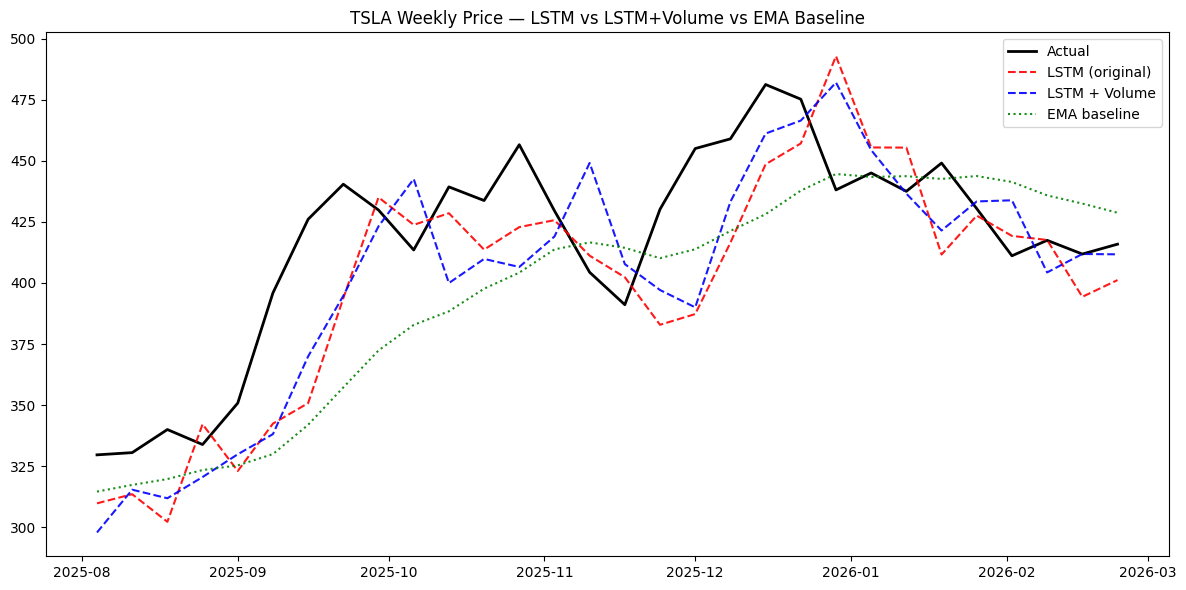

In [8]:
def get_metrics(df_pred):
    y = df_pred["y_true"].to_numpy()
    yhat = df_pred["y_pred"].to_numpy()
    mae = np.mean(np.abs(y - yhat))
    rmse = sqrt(np.mean((y - yhat) ** 2))
    mape = np.mean(np.abs((y - yhat) / np.where(y != 0, y, 1e-8))) * 100
    return {"MAE": mae, "RMSE": rmse, "MAPE_%": mape}

# Compare all three models
metrics_lstm = get_metrics(lstm_results)
metrics_lstm_exog = get_metrics(lstm_exog_results)
metrics_ema = get_metrics(ema_baseline_results)

compare = pd.DataFrame({
    "LSTM (original)": metrics_lstm,
    "LSTM + Volume": metrics_lstm_exog,
    "EMA baseline": metrics_ema,
})
print("\n--- Comparison: LSTM vs LSTM+Volume vs EMA baseline ---")
print(compare.round(4))

plt.figure(figsize=(12, 6))
plt.plot(lstm_results.index, lstm_results["y_true"], label="Actual", color="black", linewidth=2)
plt.plot(lstm_results.index, lstm_results["y_pred"], label="LSTM (original)", color="red", linestyle="--", alpha=0.9)
plt.plot(lstm_exog_results.index, lstm_exog_results["y_pred"], label="LSTM + Volume", color="blue", linestyle="--", alpha=0.9)
plt.plot(ema_baseline_results.index, ema_baseline_results["y_pred"], label="EMA baseline", color="green", linestyle=":", alpha=0.9)
plt.title(f"{SYMBOL} Weekly Price — LSTM vs LSTM+Volume vs EMA Baseline")
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# # Path setup
# OUTDIR = REPO_ROOT / "model" / "notebooks" / "artifacts"
# OUTDIR.mkdir(parents=True, exist_ok=True)

# lstm_path = OUTDIR / "pred_lstm_weekly_price.parquet"

# # Ensure timestamp is datetime before saving
# lstm_to_save = lstm_results.reset_index()
# lstm_to_save["timestamp"] = pd.to_datetime(lstm_to_save["timestamp"])

# lstm_to_save.to_parquet(lstm_path, index=False)

# print(f"LSTM predictions saved to: {lstm_path}")